### References:
Stanford course http://web.stanford.edu/class/cs224n/  
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/47581


In [92]:
import spacy
from spacy import displacy
nlp = spacy.load('en')

In [93]:
import autocorrect
from autocorrect import spell
spell('aaaventure')

'adventure'

https://github.com/phatpiglet/autocorrect/

In [94]:
import enchant
d = enchant.Dict("en_US")
d.check("Helo")

False

http://pythonhosted.org/pyenchant/tutorial.html

In [95]:
d.check("Helo")

False

In [96]:
d.suggest("Helo")

['He lo',
 'Hole',
 'Hello',
 'Helot',
 'Halo',
 'Hero',
 'Hell',
 'Held',
 'Helm',
 'Help',
 'Helios',
 'Helyn',
 'Helsa',
 'Helli']

In [97]:
from textblob import TextBlob

TextBlob: http://textblob.readthedocs.io/en/dev/quickstart.html#spelling-correction

In [98]:
test = TextBlob('Helo')
test.correct()

TextBlob("Felo")

In [99]:
%matplotlib inline
import re

import itertools
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

import seaborn as sns
import nltk
import numpy as np
import pandas as pd
from collections import Counter
from scipy.misc import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import random
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import wordnet
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from IPython.core.display import display, HTML
import IPython.display
%matplotlib inline

# Load the data

In [100]:
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

In [101]:
print("Shape of the data: {}".format(train_data.shape))

Shape of the data: (159571, 8)


In [102]:
train_size=train_data.shape[0]

In [103]:
train_data.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [104]:
# There are 6 types: 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate'.
types = train_data.columns[2:]
train_text = train_data['comment_text']

In [105]:
train_targets = train_data[types]

# Text statistics

In [106]:
train_length = train_text.str.len()

In [107]:
average_length_comment = train_length.mean()
print("Average legth of a comment: {}".format(average_length_comment))

Average legth of a comment: 394.0732213246768


In [108]:
total_length_comments = train_length.sum()
print("Total number of characters: {} (= 62 millions)".format(total_length_comments))

Total number of characters: 62882658 (= 62 millions)


In [109]:
def sent_tok(text):
    """Takes a text and returns a list of sentences."""
    return nltk.sent_tokenize(text)
def tokenize(sentence):
    """Takes a sentence and returns a tokenized one."""
    return nltk.word_tokenize(sentence)

stopwords = nltk.corpus.stopwords.words("english")
def remove_stopwords(a):
    """Takes an array of words and returns the same array with stopwords removed."""
    return [w for w in a if w.lower() not in stopwords]
def pos_tag(tokenized_sentence):
    return nltk.pos_tag(tokenized_sentence)

wordnet_lemmatizer = WordNetLemmatizer()
# wordnet_lemmatizer.lemmatize('leaves')
# wordnet_lemmatizer.lemmatize('leaves','n')
# wordnet_lemmatizer.lemmatize('leaves','v')
def convert_tag(tag):
    """Convert the tag given by nltk.pos_tag to the tag used by wordnet.synsets"""
    tag_dict = {'N': 'n', 'J': 'a', 'R': 'r', 'V': 'v'}
    try: return tag_dict[tag[0]]
    except KeyError: return 'n'
def convert_tagged(tagged):
    word = tagged[0]
    tag = tagged[1]
    return word, convert_tag(tag)

def lemmatize_sentence(sentence):
    tokenized = tokenize(sentence)
    pos_tagged = pos_tag(tokenized)
    pos_tagged_wn = (convert_tagged(w) for w in pos_tagged)
    return [wordnet_lemmatizer.lemmatize(*w) for w in pos_tagged_wn]
def is_word(w):
    return bool(re.match(r'\w',w))
def remove_punctuation(sentence):
    return [w for w in sentence if is_word(w)]

In [110]:
# train_tokens = train_text.apply(lambda sent: lemmatize_sentence(sent))
# pickle.dump(train_tokens,open("train_tokens","wb"))
train_tokens = pickle.load(open("train_tokens","rb"))

In [111]:
chain = itertools.chain(*train_tokens)
list_of_tokens = list(chain)
print("Total number of tokens: {}".format(len(list_of_tokens)))

Total number of tokens: 12817094


In [112]:
# TURN IN LOWER CASE
chain = itertools.chain(*train_tokens)
set_of_tokens = set(chain)
list_of_set_of_tokens = list(set_of_tokens)
print("Total number of distinct tokens: {}".format(len(set_of_tokens)))

Total number of distinct tokens: 293497


In [113]:
random.choice(list_of_set_of_tokens)

'EDUCATED'

# Playground

In [114]:
def get_random_comment(num=1):
    for i in range(num):
        col=np.random.randint(train_size)
        print("Comment: {}.".format(col))
        print(train_text[col])
        print("TARGETS: ",train_targets.iloc[col].values)
        print("\n"+"**"*45)
        print("**"*45 + "\n")

In [115]:
get_random_comment(num=1)

Comment: 114928.
This is a proof of a fake identity. In addition, it was incorrect to list Baha'i & Yazdânism Religions in that previously mentioned template...68.100.166.227
TARGETS:  [0 0 0 0 0 0]

******************************************************************************************
******************************************************************************************



In [116]:
def sent_nonempty(sentence):
    """Check if a sentence is not empty (or nearly empty)"""
    return re.search(r'\w\w',sentence)
def process_sentence(sentence):
    pass
def remove_empty_sentences(sentences):
    """Take a liste of sentences and remove the sentences which are empty."""
    return[sentence for sentence in sentences if sent_nonempty(sentence)]
# list(remove_empty_sentences(example1))

In [117]:
def remove_newlines(sentences):
    return [ sent for sentence in sentences  for sent in sentence.split("\n") if sent_nonempty(sent)  ]
# a = "\n ok \n ok\n".split("\n")
# remove_newlines(a)

In [118]:
train_text1=train_text.apply(nltk.sent_tokenize)

In [119]:
train_text2=train_text1.apply(remove_newlines)

In [120]:
#train_text2 = train_text1.apply(remove_empty_sentences)

In [121]:
# train_text3 = train_text.apply(sent_tok)
# train_text4 = train_text3.apply(remove_empty_sentences)

In [122]:
train_text4=train_text2

In [123]:
train_text4.head()

0    [Explanation, Why the edits made under my user...
1    [D'aww!, He matches this background colour I'm...
2    [Hey man, I'm really not trying to edit war., ...
3    [More, I can't make any real suggestions on im...
4    [You, sir, are my hero., Any chance you rememb...
Name: comment_text, dtype: object

In [124]:
#train_text4= train_text4.apply(strip_sentences)

In [125]:
def strip_sentences(sentences):
    sentences[0] = sentences[0].lstrip()
    sentences[-1] = sentences[-1].rstrip()
    return sentences

In [126]:
strip_sentences(['\n ok ii','ok ','humm \n'])

['ok ii', 'ok ', 'humm']

In [127]:
line = 0
def print_random_line(num=1,pos='first_and_last',doc=train_text4):
    for i in range(num):
        col = np.random.randint(train_size)
        print("Comment {}".format(col))
        comment = doc[col]
        if pos=='first_and_last':
            print("FIRST LINE: "+ comment[0])
            print("LAST LINE: "+ comment[-1])
        elif pos=='first':
            print("FIRST LINE: "+comment[0])
        if pos=='last':
            print("LAST LINE: "+comment[-1])
        print("TARGETS: ",train_targets.iloc[col].values)
        print("\n"+"="*80+"\n")
        global line
        line = col

In [128]:
num_row = 130157

In [129]:
train_text[num_row]

'Fixed Up article\nI Just fixed up her discography\n\nSales are very precise\nMusic of the sun sold 472K (worldwide 1.9M)\nA Girl Like Me 700K (so far)(worldwide 1.4M)'

In [130]:
train_text4[num_row]

['Fixed Up article',
 'I Just fixed up her discography',
 'Sales are very precise',
 'Music of the sun sold 472K (worldwide 1.9M)',
 'A Girl Like Me 700K (so far)(worldwide 1.4M)']

In [131]:
print_random_line(num=10)

Comment 37482
FIRST LINE: I want you to know that I intend to hold you to your easily inferred goal to maximize the productivity of women, and I am sure you would expect nothing less of me.
LAST LINE: If I am mistaken, please let me know.
TARGETS:  [0 0 0 0 0 0]


Comment 117186
FIRST LINE: Thanks, but I think Mike's wife left him or something because he won't let me edit anything.
LAST LINE: Thanks, but I think Mike's wife left him or something because he won't let me edit anything.
TARGETS:  [0 0 0 0 0 0]


Comment 60709
FIRST LINE:  Yet my last sentence in my foregoing post is perfectly veridical.
LAST LINE: Jeffro77's edit is so ridiculously biased and illogical that it's a sick joke.74.4.222.208  "
TARGETS:  [0 0 0 0 0 0]


Comment 135735
FIRST LINE: Happy Easter! 
LAST LINE: Happy Easter! 
TARGETS:  [0 0 0 0 0 0]


Comment 100230
FIRST LINE: Like I said Makedonij, it should be no suprise that so many Greeks and Bulgarians are obsessed with Macedonia related issues... after all Gr

In [132]:
train_text4[line]

[', disagreement is not an attack.',
 ', disagreement is not an attack.',
 'But, I understand that you see any disagreement as an attack.',
 'I fully understand that.',
 'Your types are hard-wired like that.',
 'It is impossible for you to see a disagreement as simply that: a disagreement.',
 'No, you see it as an attack.',
 'I understand.',
 'You are like that.',
 'And nothing can change you.',
 'That is why you see a disagreement as edit-warring too.',
 'You have a wild imagination.',
 'And here on Wikipedia you can abuse other editors as you like and as you do.',
 'That actually makes Wikipedia what it is.',
 'So, keep up your abuse.',
 'Wikipedia needs editors like you and Ladislav Mecir to abuse good-faith editors.']

## Playground with Spacy

In [133]:
from IPython.core.display import display, HTML
import IPython.display
nlp = spacy.load('en')

In [134]:
text_spacy = u"This is a text used for an example for Koen and Florent and for Kaggle. Feb 7, 2018."
doc1 = nlp(text_spacy)

In [135]:
# html = displacy.render(doc1, style='dep')
# display(HTML(html))

In [136]:
html = displacy.render(doc1, style='ent',page=True)
display(HTML(html))

In [137]:
for token in doc1:
    print(token.text,":   ", token.lemma_, token.pos_, token.tag_, token.dep_,
          token.shape_, token.is_alpha, token.is_stop)

This :    this DET DT nsubj Xxxx True False
is :    be VERB VBZ ROOT xx True True
a :    a DET DT det x True True
text :    text NOUN NN attr xxxx True False
used :    use VERB VBN acl xxxx True True
for :    for ADP IN prep xxx True True
an :    an DET DT det xx True True
example :    example NOUN NN pobj xxxx True False
for :    for ADP IN prep xxx True True
Koen :    koen PROPN NNP pobj Xxxx True False
and :    and CCONJ CC cc xxx True True
Florent :    florent PROPN NNP conj Xxxxx True False
and :    and CCONJ CC cc xxx True True
for :    for ADP IN conj xxx True True
Kaggle :    kaggle PROPN NNP pobj Xxxxx True False
. :    . PUNCT . punct . False False
Feb :    feb PROPN NNP ROOT Xxx True False
7 :    7 NUM CD nummod d False False
, :    , PUNCT , punct , False False
2018 :    2018 NUM CD npadvmod dddd False False
. :    . PUNCT . punct . False False


### Named Entity Recognation (NER) with SpaCy

In [51]:
import en_core_web_sm
nlp2 = en_core_web_sm.load()

In [52]:
print_ner(nlp2,text)

Roger Sandilands 94 110 PERSON
American National Biography   178 207 ORG
ANB 222 225 ORG
05:05 359 364 CARDINAL
11 366 368 DATE
UTC 379 382 ORG


In [144]:
import en_core_web_md
nlp3 = en_core_web_md.load()

In [145]:
print_ner(nlp3,text)

No, not when it's a patent hoax. 24.182.64.206
24.182.64.206 33 46 CARDINAL


In [146]:
import en_core_web_lg
nlp4 = en_core_web_lg.load()

In [147]:
print_ner(nlp4,text)

No, not when it's a patent hoax. 24.182.64.206


In [57]:
nlp5 = spacy.load('en_vectors_web_lg')

In [85]:
doc=nlp5('Fixed Up article I Just fixed up her discography Sales are very precise Music of the sun sold 472K (worldwide 1.9M) A Girl Like Me 700K (so far)(worldwide 1.4M)')

In [148]:
def print_ner(model,text="",row=None,train_text=train_text4):
    if row:
        text=" ".join(train_text4[row])
    else:
        if not text: print("text and row empty")
    doc = model(text)
    print(doc)
    for ent in doc.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)        

In [149]:
text = train_text[50483]

In [150]:
print_ner(nlp,text)

No, not when it's a patent hoax. 24.182.64.206
24.182.64.206 33 46 CARDINAL


In [162]:
print_ner(nlp4,row=113697)

March 2008 (UTC) So now what? Do we just go ahead and remove it? 03:28, 27
March 2008 0 10 DATE
UTC 12 15 ORG
03:28 65 70 TIME
27 72 74 CARDINAL


### NER with NLTK

In [91]:
def ner_nltk(text):
    a = nltk.pos_tag(nltk.word_tokenize(doc))
    t=nltk.ne_chunk(a)
    print(str(t))

In [364]:
doc = train_text[107077]
doc='the weather is nice today April 3, 1985.'

In [365]:
a = nltk.pos_tag(nltk.word_tokenize(doc))

In [366]:
t=nltk.ne_chunk(a)

In [367]:
print(str(t))

(S
  the/DT
  weather/NN
  is/VBZ
  nice/JJ
  today/NN
  April/NNP
  3/CD
  ,/,
  1985/CD
  ./.)


### NER with Stanford NLP

In [233]:
from stanfordcorenlp import StanfordCoreNLP

In [237]:
nlp = StanfordCoreNLP(r'/Users/florentmartin/stanford-corenlp-full-2018-01-31/')

In [239]:
print(nlp.ner(text))

[('I', 'O'), ('have', 'O'), ('replaced', 'O'), ('the', 'O'), ('initial', 'O'), ('version', 'O'), ('of', 'O'), ('the', 'O'), ('article', 'O'), ('with', 'O'), ('an', 'O'), ('alternate', 'O'), ('version', 'O'), ('emailed', 'O'), ('to', 'O'), ('me', 'O'), ('by', 'O'), ('Roger', 'PERSON'), ('Sandilands', 'PERSON'), ('.', 'O'), ('The', 'O'), ('original', 'O'), ('version', 'O'), ('was', 'O'), ('the', 'O'), ('same', 'O'), ('as', 'O'), ('what', 'O'), ('Sandilands', 'PERSON'), ('submitted', 'O'), ('to', 'O'), ('American', 'ORGANIZATION'), ('National', 'ORGANIZATION'), ('Biography', 'ORGANIZATION'), ('-LRB-', 'O'), ('and', 'O'), ('for', 'O'), ('which', 'O'), ('ANB', 'ORGANIZATION'), ('holds', 'O'), ('the', 'O'), ('copyright', 'O'), ('-RRB-', 'O'), ('.', 'O'), ('I', 'O'), ('deleted', 'O'), ('the', 'O'), ('original', 'O'), ('version', 'O'), ('to', 'O'), ('avoid', 'O'), ('a', 'O'), ('copyvio', 'O'), ('problem', 'O'), (',', 'O'), ('and', 'O'), ('recreated', 'O'), ('the', 'O'), ('page', 'O'), ('with',

### With pycorenlp
https://github.com/smilli/py-corenlp
In the terminal, enter the command:

java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 15000

then the following can work

In [274]:
from pycorenlp import StanfordCoreNLP

In [275]:
nlp = StanfordCoreNLP('http://localhost:9000')

In [276]:
text

'I have replaced the initial version of the article with an alternate version emailed to me by Roger Sandilands. The original version was the same as what Sandilands submitted to American National Biography  (and for which ANB holds the copyright). I deleted the original version to avoid a copyvio problem, and recreated the page with the alternate version.  05:05, 11 Jul 2004 (UTC)'

In [285]:
# output = nlp.annotate(text, properties={
#   'annotators': 'tokenize,ssplit,pos,depparse,parse,ner',
#   'outputFormat': 'json'
#   })
output = nlp.annotate(text, properties={
  'annotators': 'ssplit,ner,depparse',
  'outputFormat': 'json'
  })

In [286]:
last_sentence = output['sentences'][-1]
last_sentence.keys()

dict_keys(['index', 'basicDependencies', 'enhancedDependencies', 'enhancedPlusPlusDependencies', 'entitymentions', 'tokens'])

In [370]:
last_sentence['enhancedDependencies'];

### Stanford NER with nltk
https://stackoverflow.com/questions/34037094/setting-nltk-with-stanford-nlp-both-stanfordnertagger-and-stanfordpostagger-fo

In [306]:
from nltk.tag.stanford import CoreNLPPOSTagger, CoreNLPNERTagger

In [307]:
tagger1 = CoreNLPPOSTagger(url='http://localhost:9000',encoding='utf8')
tagger2 = CoreNLPNERTagger(url='http://localhost:9000',encoding='utf8')

In [310]:
tagger2.tag(u'Some text with.'.split())

[('Some', 'O'), ('text', 'O'), ('with', 'O'), ('.', 'O')]

In [371]:
import os
from nltk.parse import stanford
os.environ['STANFORD_PARSER'] = r'/Users/florentmartin/stanford-corenlp-full-2018-01-31/'
os.environ['STANFORD_MODELS'] = r'/Users/florentmartin/stanford-corenlp-full-2018-01-31/'

In [ ]:
parser = stanford.StanfordParser(model_path="/location/of/the/englishPCFG.ser.gz")
sentences = parser.raw_parse_sents(("Hello, My name is Melroy.", "What is your name?"))
print sentences

### With CountVectorizer

In [70]:
countvect = CountVectorizer()
countvect.fit(train_text)
list_of_features1=countvect.get_feature_names()
print("Numberof features with raw Countvectorizer: {}".format(len(list_of_features1)))

Numberof features with raw Countvectorizer: 189775


In [71]:
countvect2 = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
countvect2.fit(train_text)
list_of_features2=countvect2.get_feature_names()
print("Numberof features with option Countvectorizer: {}".format(len(list_of_features2)))

Numberof features with option Countvectorizer: 74684


In [76]:
random.choices(list_of_features2,k=30)

['digger',
 'fluoroquinolone',
 'dabbling',
 'i8',
 'witout',
 'motivations',
 'swiftly',
 'provisioning',
 'rectum',
 'andrea',
 'felon',
 'noteability',
 'jubilee',
 'disapproval',
 'kober',
 'buchanan',
 'curtail',
 'extensible',
 'mohammedan',
 'beatle',
 'populum',
 'afaict',
 'styrofoam',
 'xenu',
 'carpenters',
 'neccesary',
 'lesion',
 'naturopathy',
 '795',
 'shaken']

# Playground with tokens

In [45]:
set_of_tokens1={token.lower() for token in set_of_tokens}
list_of_set_of_tokens1 = list(set_of_tokens1)

In [46]:
len(list_of_set_of_tokens1)

251814

In [47]:
random.choice(list_of_set_of_tokens1)

'psychokirby'

In [48]:
wn

<WordNetCorpusReader in '/Users/florentmartin/nltk_data/corpora/wordnet'>

In [49]:
wn.synsets('misssunderstanding')

[]

In [51]:
re.findall(r'(\w)\1{2,}','aeaa')

[]

In [52]:
re.sub(r'(\w)\1{2,}',r'\1\1',"aaaaaaaabcddeeeeeeefggggghhh ")

'aabcddeefgghh '

In [53]:
def replace_word(word):
    if wn.synsets(word): return word
    
    num_consecutive_letters = len(re.findall(r'(\w)\1{2,}',word))
    
    if num_consecutive_letters==1:
        word1 = re.sub(r'(\w)\1{2,}',r'\1\1',word)
        if wn.synsets(word1): return word1 
        word2 = re.sub(r'(\w)\1',r'\1',word1)
        if wn.synsets(word2): return word2
    
    return word

In [54]:
replace_word('illlluzsion')

'illlluzsion'

In [55]:
countvect = CountVectorizer(ngram_range=(1,2))
countvect.fit(train_text)

SyntaxError: invalid syntax (<ipython-input-55-ec5af292e4f9>, line 3)

In [ ]:
countvect = CountVectorizer(ngram_range=(1,2))
countvect.fit(train_text)

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
porter_stemmer = nltk.stem.PorterStemmer()
lancaster_stemmer = nltk.stem.LancasterStemmer()
snowball_stemmer=nltk.stem.SnowballStemmer('english')
# porter_stemmer.stem('loving')

In [ ]:
porter_stemmer.stem('fuckrrrres')

In [ ]:
lemmatize_sentence('this is a sentence')

In [ ]:
train_targets.mean()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_text, train_targets, test_size=0.1, random_state=42)

In [56]:
count_vect = CountVectorizer(ngram_range=(1,2))

In [57]:
X_train_counts = count_vect.fit_transform(X_train)

NameError: name 'X_train' is not defined

In [58]:
X_val_counts = count_vect.transform(X_val)

NameError: name 'X_val' is not defined

In [59]:
mnnb = MultinomialNB()

In [60]:
toxic = y_train['toxic']
identity_hate = y_train['identity_hate']

NameError: name 'y_train' is not defined

In [61]:
mnnb.fit(X_train_counts, toxic)

NameError: name 'X_train_counts' is not defined

In [62]:
mnnb.score(X_train_counts, toxic)

NameError: name 'X_train_counts' is not defined

In [63]:
mnnb.predict_proba(X_val_counts).shape

NameError: name 'X_val_counts' is not defined

In [64]:
pred = mnnb.predict_proba(X_val_counts)[:,1]

NameError: name 'X_val_counts' is not defined

In [18]:
pred.shape

(15958,)

In [19]:
(pred == y_val['toxic']).mean()

0.028261686928186491

In [20]:
metrics.confusion_matrix(y_val['toxic'], pred)

ValueError: Can't handle mix of binary and continuous

In [21]:
metrics.roc_auc_score(y_val['toxic'], pred)

0.83354339109104969

In [22]:
toxic.shape

(143613,)

In [23]:
pred[0]

7.0232827978451271e-28

In [24]:
fpr, tpr, thresholds = metrics.roc_curve(y_val['toxic'], pred, pos_label=1)

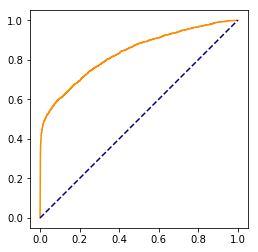

In [25]:
plt.figure()
plt.axes().set_aspect('equal')
plt.plot(fpr, tpr, color="darkorange")
plt.plot([0,1], [0,1], color="navy", linestyle="--")


In [26]:
mnnb.fit(X_train_counts, y_train['identity_hate'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [27]:
pred_idhate = mnnb.predict_proba(X_val_counts)[:,1]

In [28]:
fpr, tpr, thresholds = metrics.roc_curve(y_val['identity_hate'], pred_idhate, pos_label=1)

In [29]:
fpr_c, tpr_c, thresholds_c = metrics.roc_curve(y_val['identity_hate'], np.zeros_like(y_val['identity_hate']), pos_label=1)

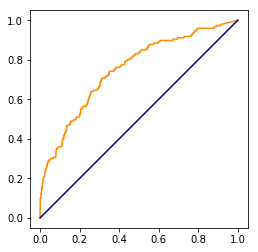

In [30]:
plt.figure()
plt.axes().set_aspect('equal')
plt.plot(fpr, tpr, color="darkorange")
plt.plot(fpr_c, tpr_c, color="navy")


# RNN
Possible references:
https://www.kaggle.com/sbongo/for-beginners-tackling-toxic-using-keras